In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.pyplot import imread
from ffht import fht

In [3]:
seed(42)
n = 300
d = n
x = rand(d)
A = rand(n, d)
b = np.abs(A.dot(x))

In [4]:
def f(w, x, nu):
    return np.abs(w - b).sum() + 1/(2*nu)*norm(A.dot(x) - w)**2

def grad_g(w, nu):
    x_star = lstsq(A, w, rcond=None)[0]
    return 1/nu*(w - A.dot(x_star))

def prox_h(z, nu):
    y = ((abs(z) - b - nu).clip(0, None) - (-abs(z) + b - nu).clip(0, None) + b)
    return y*sign(z)

def pgd(f, grad, prox, w0, nu = 1, maxIter=1000, tol=1e-3):
    log = {"func_val_x" : [], "func_val_w" : []}
    w = w0
    w_prev = inf
    k = 0
    while (norm(w_prev-w) > tol) and k < maxIter:
        x = lstsq(A, w, rcond=None)[0]
        log["func_val_x"].append(f(w, x, nu))
        w_prev = w
        w = prox(A.dot(x), nu)
        log["func_val_w"].append(f(w, x, nu))
        k += 1
    return w, log

## Dummy test

In [5]:
w_star, log = pgd(f, grad_g, prox_h, A.dot(x + 0.1*rand(d)), nu=0.5, maxIter=40)

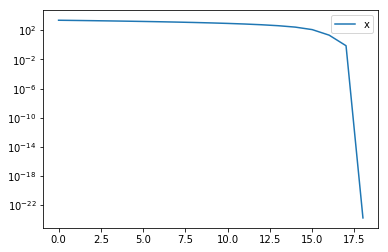

In [9]:
semilogy(log["func_val_x"], label="x")
legend()

## Real Grayscale Images 

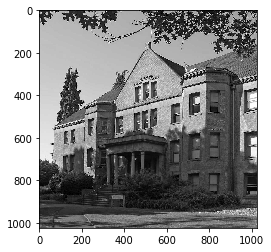

In [11]:
lewis = imread("lewis_grayscale.jpg")[:,:, 0]
imshow(lewis)
gray()

In [12]:
m, n = lewis.shape
lewis = lewis.reshape(m*n)

In [13]:
def corrupt(data, p=0.1):
    noise = rand(len(data)) > p
    return data * noise

In [46]:
corrupted_lewis = corrupt(lewis, p=0.9)

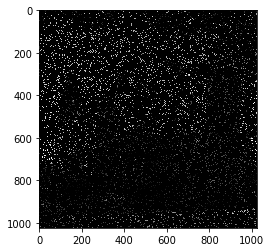

In [47]:
imshow(corrupted_lewis.reshape((m, n)))
gray()

In [48]:
def pad_to_power_of_two(arr, const=0):
    nextPower = np.ceil(np.log2((len(arr))))
    deficit = int(np.power(2, nextPower) - len(arr))
    return pad(arr, ((0, deficit)), 'constant'), deficit

#x, tail = pad_to_power_of_two(corrupted_lewis)

k = 4
seed(42)
S = rand(k, len(lewis))
S = (S > 0.5)*2-1

def Adot(x, k = k, S = S):
    m = len(x)
    result = zeros(k*m)
    for i, s in enumerate(S):
        result[i*m:i*m+m] = (s*x).astype(np.float32)
        fht(result[i*m:i*m+m])
    return result/sqrt(k*m)

def ATdot(w, k=k, S = S):
    result = zeros(int(len(w)/k))
    m = len(result)
    for i, s in enumerate(S):
        t = w[i*m:i*m+m]
        fht(t)
        result += s*t
    return result/sqrt(k*m)


b = np.abs(Adot(lewis))
w_star = Adot(lewis)
# D = zeros(k*len(x))
# D[:len(x)] = S[0]*S[1] + S[0]*S[2] + S[0]*S[3]
# D[len(x):2*len(x)] = S[1]*S[0] + S[1]*S[2] + S[1]*S[3]
# D[2*len(x):3*len(x)] = S[2]*S[0] + S[2]*S[1] + S[2]*S[3]
# D[3*len(x):] = S[3]*S[0] + S[3]*S[1] + S[3]*S[2]

In [49]:
def f(w, x, nu):
    return np.abs((np.abs(w) - b)).sum() + 1/(2*nu)*norm(Adot(x) - w)**2

def grad_g(w, nu):
    return 1/nu*(w*(1-1/k) - 1/k*D*w)

def prox_h(z, nu):
    y = ((abs(z) - b - nu).clip(0, None) - (-abs(z) + b - nu).clip(0, None) + b)
    return y*sign(z)

def pgd(f, grad, prox, w0, nu = 1, maxIter=2000, tol=1e-3):
    log = {"func_val" : [], "opt_cond" : []}
    w = w0
    c = 0
    iter_num = 0
    x = 0
    x_prev = 30
    w_prev = 30
    while (norm(x_prev-x) > tol) and iter_num < maxIter:
        x_prev = x
        x = ATdot(w)
        w = prox(Adot(x), nu)
        log["opt_cond"].append(norm(x_prev - x))
        f_val = f(w, x, nu)
        log["func_val"].append(f_val)
        iter_num += 1
    return w, log

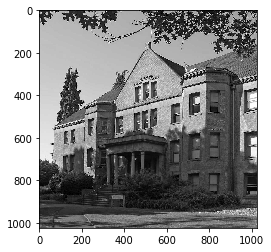

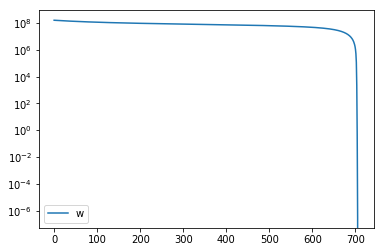

In [50]:
x0 = corrupted_lewis
w0 = Adot(x0)
nu = 0.5
f_min = f(w_star, lewis, nu)
w_pred, log = pgd(f, grad_g, prox_h, w0 = w0, nu = nu, tol=1e-3)
x_pred = ATdot(w_pred).reshape((m, n))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()